<a href="https://colab.research.google.com/github/aangelopoulos/ltt/blob/main/Detectron2%2BLTT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learn then Test, with Detectron2

<img src="http://people.eecs.berkeley.edu/~angelopoulos/media_public/ltt-detectron2-logo.png" width="600">

This is the official colab tutorial for Learn then Test. We will go over how to imbue the Detectron2 instance segmentation model with rigorous statistical guarantees on recall, IOU, and prediction set coverage, following the development in our paper, <a href="https://arxiv.org/abs/2110.01052">Learn then Test: Calibrating Predictive Algorithms to Achieve Risk Control</a>.

In this Colab notebook, we will 
* Make some small modifications to the Detectron2 framework to allow us to tune the segmentation threshold and output prediction sets instead of single labels.
* Allow you to run the calibrated detector on an image of your choice.
* Show how to perform the calibration procedure.

You can make a copy of this tutorial by "File -> Open in playground mode" and make changes there. __DO NOT__ request access to this tutorial.
Make sure you're running in a GPU instance of Colab.
Finally, thank you to the Detectron2 folks for open-sourcing their inspiring code!


# Installation of LTT and Detectron2

We will now download the necessary packages, making some small modifications as needed.

You will need to restart the colab runtime after running the next cell (you will see a button after it runs).

In [1]:
!pip install pyyaml==5.1
# This is the current pytorch version on Colab. Uncomment this if Colab changes its pytorch version
# !pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html


In [2]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9")   # please manually install torch 1.9 if Colab changes its default version

1.9.0+cu111 True


In [3]:
# Download LTT framework
!rm -r ltt/
!git clone https://github.com/aangelopoulos/ltt.git
# Minor edit to the detectron source code
!cp /content/ltt/experiments/detection/postprocessing.py /usr/local/lib/python3.7/dist-packages/detectron2/modeling/postprocessing.py

Cloning into 'ltt'...
remote: Enumerating objects: 1384, done.
remote: Counting objects: 100% (1384/1384), done.
remote: Compressing objects: 100% (870/870), done.
remote: Total 1384 (delta 851), reused 966 (delta 463), pack-reused 0
Receiving objects: 100% (1384/1384), 16.16 MiB | 15.66 MiB/s, done.
Resolving deltas: 100% (851/851), done.


In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import matplotlib.pyplot as plt
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from ltt.experiments.detection.visualizer import Visualizer
from ltt.experiments.detection.UQHeads import UQHeads

# Choose your image

Go ahead and replace the following code with any image you'd like to use.
You can find some cool images from the COCO dataset here: https://cocodataset.org/#explore


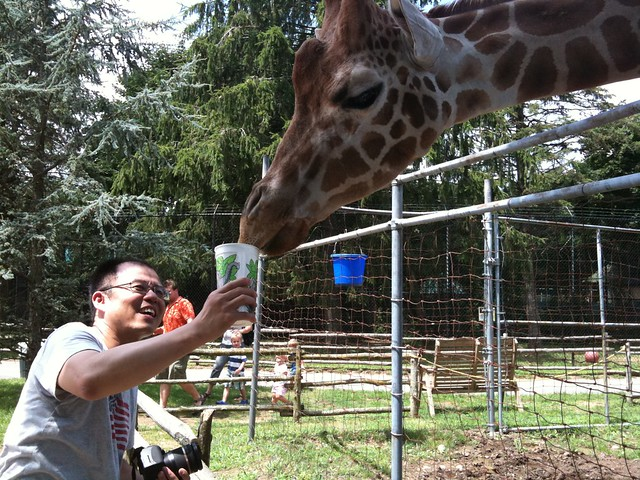

In [5]:
!wget https://farm5.staticflickr.com/4120/4827824010_a59722b4e9_z.jpg -q -O input.jpg
img = cv2.imread("./input.jpg")
cv2_imshow(img)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image, with a special UQHead that gives us access to the internal segmentation threshold and postprocessed class scores of the model.

The config includes the choices of lambda that were picked via LTT; we'll see how to pick those later!

In [6]:
cfg = get_cfg()
# Thresholds (Which were picked via LTT, as you will see later)
lambda1 = 0.682 
lambda2 = 0.4444 
lambda3 = 0.999
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NAME = "UQHeads"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 #set threshold for this model
cfg.MODEL.ROI_HEADS.APS_THRESH = lambda3
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(img)

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:115

In [7]:
# Ensure everything is on cpu
if len(outputs['instances']) == 0:
    raise Exception("Warning: Empty outputs!")
outputs['instances'] = outputs['instances'].to('cpu')
tokeep = outputs["instances"].softmax_outputs.max(dim=1)[0] > lambda1
outputs['instances'].roi_masks.tensor = outputs['instances'].roi_masks.tensor[tokeep]
outputs['instances'].pred_boxes.tensor = outputs['instances'].pred_boxes.tensor[tokeep]
outputs['instances'].pred_sets = outputs['instances'].pred_sets[tokeep]
outputs['instances'].pred_masks = outputs['instances'].roi_masks.to_bitmasks(outputs['instances'].pred_boxes,img.shape[0],img.shape[1],lambda2).tensor
outputs['instances'].softmax_outputs = outputs['instances'].softmax_outputs[tokeep]
outputs['instances'].scores = outputs['instances'].scores[tokeep]
outputs['instances'].class_ordering = outputs['instances'].class_ordering[tokeep]

# Prediction

Now we predict! Run the next cell to see the instance segmentation output, with a prediction set for each object.  The sets are guaranteed to achieve a recall of 0.5, IOU of 0.5, and prediction set coverage of 0.75 (see Section 6 of the LTT paper).

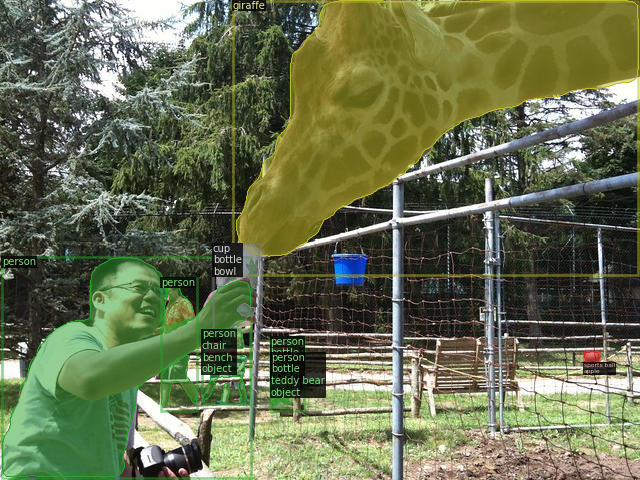

In [8]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
outImg = out.get_image()[:,:,::-1]
plt.close()
outImg = cv2.resize(outImg,dsize=(img.shape[1],img.shape[0]),interpolation=cv2.INTER_CUBIC)
cv2_imshow(outImg)

# Choosing the lambdas with LTT

Now we show a short vignette explaining how to choose the lambdas we picked above.
The first step is to define a discrete grid of lambdas, along with the values for each risk.  Here, the first alpha corresponds to prediction set coverage, the second corresponds to IOU, and the third corresponds to recall.
We also want to know our desired failure rate delta (in this case, 10%), and the number of calibration points we'd like to use.

In [9]:
lambda1s = torch.linspace(0.5,1,10) # Top score threshold
lambda2s = torch.linspace(0,1,10) # Segmentation threshold
lambda3s = torch.tensor([0.9,0.925,0.95,0.975,0.99,0.995,0.999,0.9995,0.9999,0.99995,1]) # APS threshold
alphas = [0.25, 0.5, 0.5]
delta = 0.1
num_calib = 3000 

Having defined the risks and their levels, we can now run the procedure.
We begin by calculating the loss for each example in the calibration and validation sets.
We precomputed this for you, but it just involves doing a single forward pass over those datasets (no backprop).

In [10]:
from ltt.experiments.detection.loss_table import get_loss_tables
from ltt.experiments.detection.cache_data import cache_data
from ltt.experiments.detection.experiment import bonferroni, split_fixed_sequence, flatten_lambda_meshgrid

try:
  loss_tables = torch.load('/content/ltt/experiments/detection/example_loss_tables.pt')
except:
  # This takes a long time, and you have to download COCO to ./datasets/coco/ if you want to run it from scratch.
  cache_data()
  loss_tables = get_loss_tables()

n = loss_tables.shape[0]

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Now, we run the multiple testing procedure.  For this example, can choose between Split-Fixed Sequence (which is more powerful), and Bonferroni. There are more flexible sequential graphical tests available if you read our LTT paper!

In [11]:
method = "Split Fixed Sequence"

perm = torch.randperm(n)

local_tables = loss_tables[perm]
calib_tables, val_tables = (local_tables[:num_calib], local_tables[num_calib:])

if method == "Bonferroni":
    p_values_corrected = calculate_corrected_p_values(calib_tables, alphas)
    R = bonferroni(p_values_corrected, delta)

elif method == "Split Fixed Sequence":
    R = split_fixed_sequence(calib_tables, alphas, delta)

if R.shape[0] == 0:
    lhats[i] = np.array([1.0,1.0,1.0])
    risks[i] = np.array([0.0,0.0,0.0])
    loss_tables["curr_proc"] -= 1

l1_meshgrid, l2_meshgrid, l3_meshgrid = flatten_lambda_meshgrid(lambda1s,lambda2s,lambda3s)

# Index the lambdas
l1s = l1_meshgrid[R]
l2s = l2_meshgrid[R]
l3s = l3_meshgrid[R]

l3 = l3s[l3s > l1s].min()
l2 = l2s[(l3s > l1s) & (l3s==l3)].median()
l1 = l1s[(l3s > l1s) & (l2s==l2) & (l3s==l3)].min()
lhat = np.array([l1,l2,l3])

print(f"Lambda hat: {lhat}")



Lambda hat: [0.5        0.44444445 0.9995    ]


/content/ltt/experiments/detection/experiment.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  l1_meshgrid, l2_meshgrid, l3_meshgrid = torch.meshgrid((torch.tensor(lambda1s),torch.tensor(lambda2s), torch.tensor(lambda3s)))


Finally, you can validate that the risks are controlled.

In [12]:
# Validate

idx1 = torch.nonzero(np.abs(lambda1s-lhat[0]) < 1e-10)[0][0].item()
idx2 = torch.nonzero(np.abs(lambda2s-lhat[1]) < 1e-10)[0][0].item()
idx3 = torch.nonzero(np.abs(lambda3s-lhat[2]) < 1e-10)[0][0].item()

risks = val_tables[:,:,idx1,idx2,idx3].mean(dim=0)
print(f"Empirical risks on validation set: {risks}")

Empirical risks on validation set: tensor([0.1935, 0.4592, 0.3603])


Great job!  You ran a Learn then Test procedure with Detectron2.
The lambdas we chose in the previous cells came from this same procedure.

Thank you to the Detectron2 team for providing their colab, which heavily influenced ours.